In [1]:
from urllib.parse import unquote

import numpy as np
import pandas as pd

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from matplotlib import pyplot as plt

In [2]:
articles_df = pd.read_csv("../data/paths-and-graph/articles.tsv", sep = "\t", comment = '#', header = None)
articles_df.columns = ['article_name']

# Decode names
articles_df['article_name'] = articles_df['article_name'].apply(unquote) 

print(articles_df.shape)
articles_df.head()

(4604, 1)


,article_name
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


In [3]:
categories_df = pd.read_csv("../data/paths-and-graph/categories.tsv", sep = "\t", comment = '#', header = None)
categories_df.columns = ['article_name', 'category']

# Decode article names
categories_df['article_name'] = categories_df['article_name'].apply(unquote)

# Split the 'category' column into multiple columns (one for each level of category)
df_split = categories_df['category'].str.split('.', expand=True).drop(columns=[0])

# Rename the columns to represent each level
df_split.columns = ['Level_1', 'Level_2', 'Level_3']

# Join the new columns with starting dataframe
categories_df = categories_df.drop(columns = ['category']).join(df_split)

print(categories_df.shape)
categories_df.head()

(5204, 4)


,article_name,Level_1,Level_2,Level_3
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,None


In [4]:
links_df = pd.read_csv("../data/paths-and-graph/links.tsv", sep = "\t", comment = '#', header = None)
links_df.columns = ['source', 'target']

# Decode article names
links_df = links_df.map(unquote)

print(links_df.shape)
links_df.head()

(119882, 2)


,source,target
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [5]:
finished_df = pd.read_csv("../data/paths-and-graph/paths_finished.tsv", sep = "\t", comment = '#', header = None)
finished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating']

# Decode article names and transform path into list
finished_df['path'] = finished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Calculate path length
finished_df['path_length'] = finished_df['path'].apply(len)

# Calculate number of backward clicks in each path
finished_df['num_backward'] = finished_df['path'].apply(lambda a: a.count("<"))

# Convert timestamp to reasonable units 
finished_df['timestamp'] = pd.to_datetime(finished_df['timestamp'], unit='s')

finished_df.head()

,hashIP,timestamp,duration,path,difficulty_rating,path_length,num_backward
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,9,0
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,5,0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,8,0
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,4,0
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,7,0


In [6]:
unfinished_df = pd.read_csv("../data/paths-and-graph/paths_unfinished.tsv", sep = "\t", comment = '#', header = None)
unfinished_df.columns = ['hashIP', 'timestamp', 'duration', 'path', 'target_article', 'type_end']

# Decode article names and transform path to list
unfinished_df['path'] = unfinished_df['path'].apply(lambda a: [unquote(art) for art in a.split(";")])

# Decode article names and transform path to list
unfinished_df['target_article'] = unfinished_df['target_article'].apply(lambda a: unquote(a))

# Calculate length of unfinished paths
unfinished_df['path_length'] = unfinished_df['path'].apply(len)

# Calculate number of backward clicks
unfinished_df['num_backward'] = unfinished_df['path'].apply(lambda a: a.count("<"))

# Convert timestampt to reasonable units 
unfinished_df['timestamp'] = pd.to_datetime(unfinished_df['timestamp'], unit='s')

unfinished_df.head()

,hashIP,timestamp,duration,path,target_article,type_end,path_length,num_backward
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout,1,0
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout,1,0
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,3,0
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart,1,0
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,2,0


In [7]:
finished_mod = finished_df.copy()

# Keep only paths that are after the first unfinished path (to avoid bias)
finished_mod = finished_mod[finished_mod['timestamp'] > unfinished_df['timestamp'].min()]

# Extract source and target articles
finished_mod['source'] = finished_mod.path.apply(lambda a: a[0])
finished_mod['target'] = finished_mod.path.apply(lambda a: a[-1])

# Add a field that will be used to merge with the unfinished paths
finished_mod['finished'] = True

finished_mod = finished_mod.reindex(sorted(finished_mod.columns), axis=1)
print(finished_mod.shape)
finished_mod.head()

(23245, 10)


,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40
4,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08
5,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54


In [8]:
unfinished_mod = unfinished_df.copy()

# Extract source article
unfinished_mod['source'] = unfinished_mod.path.apply(lambda a: a[0])
unfinished_mod.rename(columns={'target_article': 'target'}, inplace=True)

# Add a field that will be used to merge with the finished paths
unfinished_mod['finished'] = False

unfinished_mod = unfinished_mod.reindex(sorted(unfinished_mod.columns), axis=1)
print(unfinished_mod.shape)
unfinished_mod.head()

(24875, 10)


,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp,type_end
0,1804,False,2426091a53125110,0,[Obi-Wan_Kenobi],1,Obi-Wan_Kenobi,Microsoft,2011-02-07 05:02:15,timeout
1,1805,False,26141fd878806294,0,[Julius_Caesar],1,Julius_Caesar,Caracas,2011-02-07 05:14:11,timeout
2,1818,False,2b015fb8181c48f2,0,"[Malawi, Democracy, Alexander_the_Great]",3,Malawi,First_Crusade,2011-02-07 15:00:19,timeout
3,49,False,53a53bc244e08a6a,0,[Paraguay],1,Paraguay,Mount_St._Helens,2011-02-07 16:06:01,restart
4,1808,False,53a53bc244e08a6a,0,"[Paraguay, Bolivia]",2,Paraguay,Mount_St._Helens,2011-02-07 17:18:25,timeout


In [9]:
valid_games = pd.concat([finished_mod, unfinished_mod], ignore_index = True)

# Drop the type of the end of the path because it is not relevant
valid_games.drop('type_end', axis = 1, inplace = True)
print("There are {} valid games".format(valid_games.shape[0]))

# Check that all source and target articles are in the articles dataframe and print which are not
print("Source articles not in articles dataframe:")
print(valid_games[~valid_games['source'].isin(articles_df['article_name'])]['source'].unique())
print("Target articles not in articles dataframe:")
print(valid_games[~valid_games['target'].isin(articles_df['article_name'])]['target'].unique())

# Drop rows with source or target articles not in the articles dataframe
valid_games = valid_games[valid_games['source'].isin(articles_df['article_name'])]
valid_games = valid_games[valid_games['target'].isin(articles_df['article_name'])]

print(valid_games.shape)
print(valid_games.columns)
valid_games.head()

There are 48120 valid games
Source articles not in articles dataframe:
[]
Target articles not in articles dataframe:
['Long_peper' 'Test' 'Adolph_Hitler' 'Netbook' 'Podcast' 'Christmas'
 'Sportacus' 'Charlottes_web' 'Macedonia' 'Usa' '_Zebra' 'Rss'
 'Black_ops_2' 'Western_Australia' 'The_Rock' 'Great' 'Georgia' 'English'
 'Fats' 'Mustard' 'Bogota' 'The' 'Rat' 'Kashmir']
(48092, 10)
Index(['difficulty_rating', 'duration', 'finished', 'hashIP', 'num_backward',
       'path', 'path_length', 'source', 'target', 'timestamp'],
      dtype='object')


,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54


In [10]:
# Dump source and target articles to a .txt file to be processed by the C++ code
# First take only the unique source-target pairs
unique_games = valid_games[['source', 'target']].drop_duplicates()
unique_games.to_csv('../data/paths-and-graph/unique_games.tsv', sep = '\t', index = False, header = False)

In [11]:
unique_game_stats = pd.read_csv('../data/paths-and-graph/pair_data.tsv', sep = '\t', header = None)
unique_game_stats.columns = [
    'source', 'target', 'shortest_path_length', 
    'shortest_path_count', 'max_sp_pagerank', 'max_sp_avg_pagerank', 'avg_sp_avg_pagerank',
    'one_longer_path_count', 'max_ol_pagerank', 'max_ol_avg_pagerank', 'avg_ol_avg_pagerank', 
    'two_longer_pagerank', 'max_tl_pagerank','max_tl_avg_pagerank'
]

unique_game_stats.set_index(['source', 'target'], inplace = True)

unique_game_stats.head()

shortest_path_length  \
source       target                                         
14th_century African_slave_trade                        3   
             John_F._Kennedy                            3   
             Rainbow                                    3   
             Sodium                                     3   
             Elizabeth_I_of_England                     2   

                                     shortest_path_count  max_sp_pagerank  \
source       target                                                         
14th_century African_slave_trade                       3         0.002070   
             John_F._Kennedy                          18         0.009774   
             Rainbow                                   5         0.004548   
             Sodium                                    4         0.003013   
             Elizabeth_I_of_England                    1         0.000882   

                                     max_sp_avg_pagerank  avg_sp_avg_pagerank  \
source       target                                                             
14th_century African_slave_trade                0.000759             0.000562   
             John_F._Kennedy                    0.004316             0.002362   
             Rainbow                            0.001342             0.000626   
             Sodium                             0.001054             0.000713   
             Elizabeth_I_of_England             0.000508             0.000508   

                                     one_longer_path_count  max_ol_pagerank  \
source       target                                                           
14th_century African_slave_trade                        85         0.009774   
             John_F._Kennedy                          1758         0.009774   
             Rainbow                                   198         0.006847   
             Sodium                                    548         0.009774   
             Elizabeth_I_of_England                     61         0.006847   

                                     max_ol_avg_pagerank  avg_ol_avg_pagerank  \
source       target                                                             
14th_century African_slave_trade                0.003463             0.001167   
             John_F._Kennedy                    0.004792             0.002050   
             Rainbow                            0.002413             0.000922   
             Sodium                             0.003634             0.001034   
             Elizabeth_I_of_England             0.002172             0.000932   

                                     two_longer_pagerank  max_tl_pagerank  \
source       target                                                         
14th_century African_slave_trade                     300         0.006847   
             John_F._Kennedy                         300         0.009774   
             Rainbow                                 300         0.006847   
             Sodium                                  300         0.006847   
             Elizabeth_I_of_England                  300         0.006847   

                                     max_tl_avg_pagerank  
source       target                                       
14th_century African_slave_trade                0.002470  
             John_F._Kennedy                    0.004751  
             Rainbow                            0.002735  
             Sodium                             0.002960  
             Elizabeth_I_of_England             0.002537

In [13]:
# Merge the pair data with the valid games
valid_games_reg = valid_games.merge(unique_game_stats, left_on = ['source', 'target'], right_index = True, how = 'left')

print(valid_games_reg.shape)
print(valid_games_reg.columns)
# Drop games which do not have shortest_path_length
valid_games_reg.dropna(subset = ['shortest_path_length'], inplace = True)

print("Size after dropping games without shortest path length: ")
print(valid_games_reg.shape)

(48092, 22)
Index(['difficulty_rating', 'duration', 'finished', 'hashIP', 'num_backward',
       'path', 'path_length', 'source', 'target', 'timestamp',
       'shortest_path_length', 'shortest_path_count', 'max_sp_pagerank',
       'max_sp_avg_pagerank', 'avg_sp_avg_pagerank', 'one_longer_path_count',
       'max_ol_pagerank', 'max_ol_avg_pagerank', 'avg_ol_avg_pagerank',
       'two_longer_pagerank', 'max_tl_pagerank', 'max_tl_avg_pagerank'],
      dtype='object')
Size after dropping games without shortest path length: 
(48092, 22)


In [14]:
embeddings_df = pd.read_csv('../src/data/article_embeddings_smaller.csv')

embeddings_df['article_name'] = embeddings_df['article_name'].apply(unquote)
embeddings_df.index = embeddings_df['article_name']
embeddings_df.drop(columns=['article_name'], inplace=True)
embeddings_df.sort_index(inplace=True)

# Turn the embedded value into numpy array
embeddings_df['embedding'] = embeddings_df['embedding'].apply(lambda x: np.asarray(x.replace('[', '').replace(']', '').split(', '), dtype=np.float32))
embeddings_df.head()

,embedding
article_name,
10th_century,"[-0.050105415, 0.09074813, 0.008811204, -0.051..."
11th_century,"[-0.042490385, 0.061723217, -0.020333063, -0.0..."
12th_century,"[-0.032364372, 0.037580367, -0.052070234, -0.1..."
13th_century,"[-0.07914139, 0.059444286, 0.020845776, -0.100..."
14th_century,"[-0.040906686, 0.122400954, -0.04961793, 0.007..."


In [15]:
valid_games_reg = valid_games_reg.join(embeddings_df, on = 'source')
valid_games_reg.rename(columns = {'embedding': 'embedding_source'}, inplace = True)

valid_games_reg = valid_games_reg.join(embeddings_df, on = 'target')
valid_games_reg.rename(columns = {'embedding': 'embedding_target'}, inplace = True)

# Embeddings are normalized so so a dot product is a cosine similarity
valid_games_reg['cosine_similarity'] = valid_games_reg.apply(
    lambda x: np.dot(x['embedding_source'], x['embedding_target']),
    axis=1
)
valid_games_reg.drop(columns=['embedding_source', 'embedding_target'], inplace=True)

print(valid_games_reg.shape)
print(valid_games_reg.columns)
valid_games_reg.head()

(48092, 23)
Index(['difficulty_rating', 'duration', 'finished', 'hashIP', 'num_backward',
       'path', 'path_length', 'source', 'target', 'timestamp',
       'shortest_path_length', 'shortest_path_count', 'max_sp_pagerank',
       'max_sp_avg_pagerank', 'avg_sp_avg_pagerank', 'one_longer_path_count',
       'max_ol_pagerank', 'max_ol_avg_pagerank', 'avg_ol_avg_pagerank',
       'two_longer_pagerank', 'max_tl_pagerank', 'max_tl_avg_pagerank',
       'cosine_similarity'],
      dtype='object')


,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp,...,max_sp_avg_pagerank,avg_sp_avg_pagerank,one_longer_path_count,max_ol_pagerank,max_ol_avg_pagerank,avg_ol_avg_pagerank,two_longer_pagerank,max_tl_pagerank,max_tl_avg_pagerank,cosine_similarity
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,...,0.000759,0.000562,85,0.009774,0.003463,0.001167,300,0.006847,0.002470,0.202444
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,...,0.000759,0.000562,85,0.009774,0.003463,0.001167,300,0.006847,0.002470,0.202444
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,...,0.000759,0.000562,85,0.009774,0.003463,0.001167,300,0.006847,0.002470,0.202444
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,...,0.004316,0.002362,1758,0.009774,0.004792,0.002050,300,0.009774,0.004751,0.079502
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54,...,0.004316,0.002362,1758,0.009774,0.004792,0.002050,300,0.009774,0.004751,0.079502


In [16]:
node_stats = pd.read_csv('../data/paths-and-graph/node_data.tsv', sep='\t')
node_stats.columns = ['article_name', 'degree', 'closeness', 'betweenness', 'pagerank']
node_stats.index = node_stats['article_name']
node_stats.drop(columns=['article_name'], inplace=True)

node_stats.head()

,degree,closeness,betweenness,pagerank
article_name,,,,
11th_century,48,0.336125,6652.2700,0.000595
12th_century,45,0.338172,14188.4000,0.000769
13th_century,34,0.321593,8543.7200,0.000810
14th_century,31,0.325205,5366.1500,0.000642
15th_Marine_Expeditionary_Unit,24,0.327015,20.0709,0.000024


In [17]:
valid_games_reg = valid_games_reg.join(node_stats, on = 'source')
valid_games_reg = valid_games_reg.join(node_stats, on = 'target', rsuffix = '_target')

valid_games_reg.rename(
    columns = {
        'degree': 'degree_source', 
        'closeness': 'closeness_source', 
        'betweenness': 'betweenness_source', 
        'pagerank': 'pagerank_source'
    }, 
    inplace = True
)

print(valid_games_reg.shape)
print(valid_games_reg.columns)

# Drop games which do not have node statistics
valid_games_reg.dropna(subset = ['degree_source'], inplace = True)
valid_games_reg.dropna(subset = ['degree_target'], inplace = True)
print("Size after dropping games without node statistics: ")
print(valid_games_reg.shape)

(48092, 31)
Index(['difficulty_rating', 'duration', 'finished', 'hashIP', 'num_backward',
       'path', 'path_length', 'source', 'target', 'timestamp',
       'shortest_path_length', 'shortest_path_count', 'max_sp_pagerank',
       'max_sp_avg_pagerank', 'avg_sp_avg_pagerank', 'one_longer_path_count',
       'max_ol_pagerank', 'max_ol_avg_pagerank', 'avg_ol_avg_pagerank',
       'two_longer_pagerank', 'max_tl_pagerank', 'max_tl_avg_pagerank',
       'cosine_similarity', 'degree_source', 'closeness_source',
       'betweenness_source', 'pagerank_source', 'degree_target',
       'closeness_target', 'betweenness_target', 'pagerank_target'],
      dtype='object')
Size after dropping games without node statistics: 
(48081, 31)


In [18]:

# Remove some useless columns
# valid_games_reg.drop(columns=['hashIP', 'timestamp', 'duration', 'path', 'difficulty_rating', 'path_length', 'num_backward'], inplace=True)
valid_games_reg.drop(columns=['hashIP', 'timestamp', 'path', 'difficulty_rating'], inplace=True)

# Change the type of finished to a float for logistic regression
valid_games_reg['finished'] = valid_games_reg['finished'].astype(float)

print(valid_games_reg.shape)
print(valid_games_reg.columns)

(48081, 27)
Index(['duration', 'finished', 'num_backward', 'path_length', 'source',
       'target', 'shortest_path_length', 'shortest_path_count',
       'max_sp_pagerank', 'max_sp_avg_pagerank', 'avg_sp_avg_pagerank',
       'one_longer_path_count', 'max_ol_pagerank', 'max_ol_avg_pagerank',
       'avg_ol_avg_pagerank', 'two_longer_pagerank', 'max_tl_pagerank',
       'max_tl_avg_pagerank', 'cosine_similarity', 'degree_source',
       'closeness_source', 'betweenness_source', 'pagerank_source',
       'degree_target', 'closeness_target', 'betweenness_target',
       'pagerank_target'],
      dtype='object')


In [19]:
# Separate the majority and minority classes
majority_class = valid_games_reg.copy()[valid_games_reg['finished'] == False]
minority_class = valid_games_reg.copy()[valid_games_reg['finished'] == True]

# Randomly sample from the majority class to match the minority class size
majority_sampled = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the resampled majority class with the original minority class
balanced_games = pd.concat([majority_sampled, minority_class])

# Shuffle the dataset (optional but recommended)
balanced_games = balanced_games.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print("New class distribution:\n", balanced_games['finished'].value_counts())

valid_games_reg = balanced_games
print(valid_games_reg.shape)

New class distribution:
 finished
0.0    23237
1.0    23237
Name: count, dtype: int64
(46474, 27)


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
def determine_best_thresh(model, x_train, y_train):
    thresholds = np.linspace(0.4, 0.6, 201)
    accuracies = []
    f1_scores = []
    y_pred = model.predict(x_train)
    
    for threshold in thresholds:
        y_predicted = y_pred > threshold
        
        f1_scores.append(f1_score(y_train, y_predicted, average='weighted'))
        accuracies.append(accuracy_score(y_train, y_predicted))
        
    # Determine the threshold that maximizes the F1 score
    max_f1_score = max(f1_scores)
    max_f1_score_index = f1_scores.index(max_f1_score)
    print("Max F1 Score: ", max_f1_score)
    print(f"Threshold: {thresholds[max_f1_score_index]:.4f}")
        
    plt.plot(thresholds, f1_scores)
    plt.plot(thresholds, accuracies)
    plt.xlabel("Threshold")
    
    return thresholds[max_f1_score_index]

In [22]:
x_1_features = [
    'shortest_path_length',
    'shortest_path_count',
]
x_1 = valid_games_reg.copy()[x_1_features]
# x_1['shortest_path_count'] = x_1['shortest_path_count'].apply(lambda x: np.exp(x))
x_1['shortest_path_count'] = x_1['shortest_path_count'].apply(lambda x: np.log(x + 1e-4))

y_1 = valid_games_reg['finished']

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, train_size = 0.80, random_state = 42, stratify = y_1)

# standardization
scaler = StandardScaler()

x_train_1 = scaler.fit_transform(x_train_1) # compute z-scores of train set
# x_train_1 = sm.add_constant(x_train_1) 

x_test_1 = scaler.transform(x_test_1) # use the same transformation on test set
# x_test_1 = sm.add_constant(x_test_1)


In [23]:
model_1 = sm.Logit(y_train_1, x_train_1).fit()
model_1.summary()

Optimization terminated successfully.
         Current function value: 0.649055
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                37179
Model:                          Logit   Df Residuals:                    37177
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.06361
Time:                        10:01:41   Log-Likelihood:                -24131.
converged:                       True   LL-Null:                       -25771.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7594      0.014    -52.608      0.000      -0.788      -0.731
x2             0.3494      0.013     26.951      0.000       0.324       0.375
==============================================================================
"""

Max F1 Score:  0.6192134347184567
Threshold: 0.4980


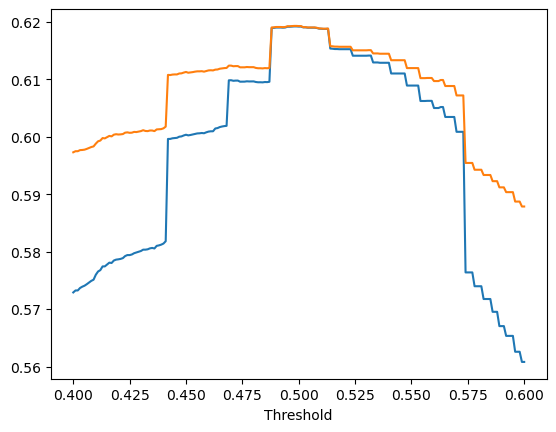

In [24]:
threshold_1 = determine_best_thresh(model_1, x_train_1, y_train_1)

In [25]:
# Verify the model on the test set
y_pred_1 = model_1.predict(x_test_1)
y_pred_1 = y_pred_1 > threshold_1
print(classification_report(y_test_1, y_pred_1, digits=3))

              precision    recall  f1-score   support

         0.0      0.631     0.614     0.622      4648
         1.0      0.624     0.641     0.632      4647

    accuracy                          0.627      9295
   macro avg      0.628     0.627     0.627      9295
weighted avg      0.628     0.627     0.627      9295



In [26]:
x_2_features = [
    'pagerank_target',
]
x_2 = valid_games_reg.copy()[x_2_features]

y_2 = valid_games_reg['finished']

# standardization
scaler = StandardScaler()

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, train_size = 0.80, random_state = 42, stratify = y_2)

x_train_2 = scaler.fit_transform(x_train_2) 
x_train_2 = sm.add_constant(x_train_2)

x_test_2 = scaler.transform(x_test_2)
x_test_2 = sm.add_constant(x_test_2)

In [27]:
model_2 = sm.Logit(y_train_2, x_train_2).fit()
model_2.summary()

Optimization terminated successfully.
         Current function value: 0.662385
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                37179
Model:                          Logit   Df Residuals:                    37177
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.04438
Time:                        10:01:45   Log-Likelihood:                -24627.
converged:                       True   LL-Null:                       -25771.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0541      0.011      4.921      0.000       0.033       0.076
x1             0.7537      0.020     38.648      0.000       0.716       0.792
==============================================================================
"""

Max F1 Score:  0.6343991921161365
Threshold: 0.4480


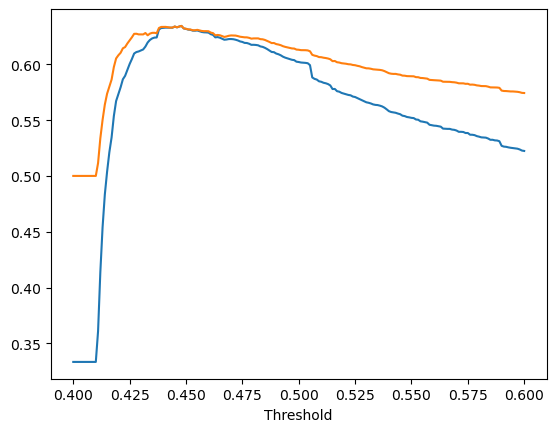

In [28]:
threshold_2 = determine_best_thresh(model_2, x_train_2, y_train_2)

In [29]:
# Verify the model on the test set
y_pred_2 = model_2.predict(x_test_2)
y_pred_2 = y_pred_2 > threshold_2
print(classification_report(y_test_2, y_pred_2, digits=3))

              precision    recall  f1-score   support

         0.0      0.643     0.654     0.649      4648
         1.0      0.648     0.637     0.643      4647

    accuracy                          0.646      9295
   macro avg      0.646     0.646     0.646      9295
weighted avg      0.646     0.646     0.646      9295



In [30]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_2, y_pred_2))

[[3040 1608]
 [1686 2961]]


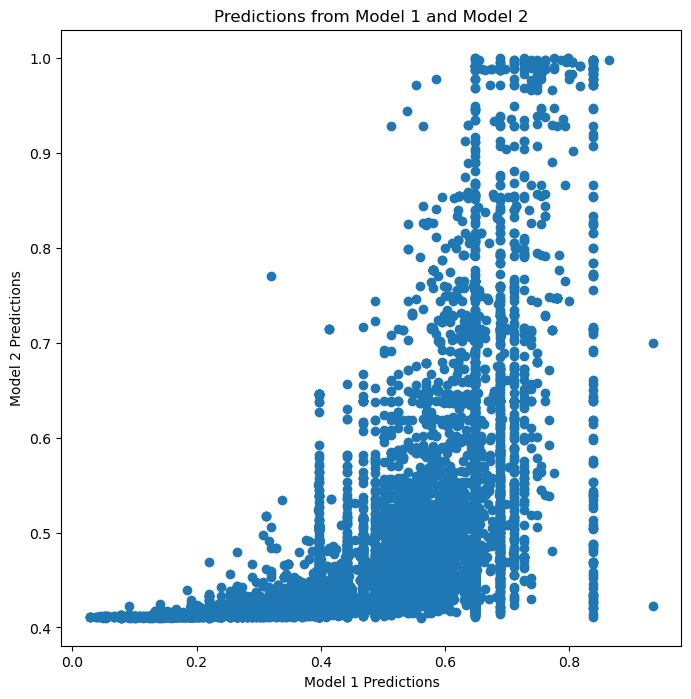

Correlation between the two models:  0.6619225971048975


In [31]:
# Scatterplot the predictions from the two models and calculate correlation
plt.figure(figsize=(8, 8))
plt.scatter(model_1.predict(x_test_1), model_2.predict(x_test_2))
plt.xlabel('Model 1 Predictions')
plt.ylabel('Model 2 Predictions')
plt.title('Predictions from Model 1 and Model 2')
plt.show()

print("Correlation between the two models: ", np.corrcoef(y_pred_1, y_pred_2)[0, 1])

In [32]:
x_3_features = [
    'one_longer_path_count',
    'max_ol_pagerank',
    'max_ol_avg_pagerank',
    'avg_ol_avg_pagerank',
]
x_3 = valid_games_reg.copy()[x_3_features]
x_3['one_longer_path_count'] = x_3['one_longer_path_count'].apply(lambda x: np.log(x + 1e-4))

y_3 = valid_games_reg['finished']

# standardization
scaler = StandardScaler()

x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3, y_3, train_size = 0.80, random_state = 42, stratify = y_2)

x_train_3 = scaler.fit_transform(x_train_3) 
# x_train_3 = sm.add_constant(x_train_3)

x_test_3 = scaler.transform(x_test_3)
# x_test_3 = sm.add_constant(x_test_3)

In [33]:
model_3 = sm.Logit(y_train_3, x_train_3).fit()
model_3.summary()

Optimization terminated successfully.
         Current function value: 0.673881
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                37179
Model:                          Logit   Df Residuals:                    37175
Method:                           MLE   Df Model:                            3
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.02780
Time:                        10:01:49   Log-Likelihood:                -25054.
converged:                       True   LL-Null:                       -25771.
Covariance Type:            nonrobust   LLR p-value:                2.455e-310
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1885      0.014    -13.366      0.000      -0.216      -0.161
x2            -0.4877      0.017    -28.253      0.000      -0.522      -0.454
x3             0.8927      0.026     34.137      0.000       0.841       0.944
x4            -0.3384      0.019    -18.211      0.000      -0.375      -0.302
==============================================================================
"""

Max F1 Score:  0.5659756802438192
Threshold: 0.4860


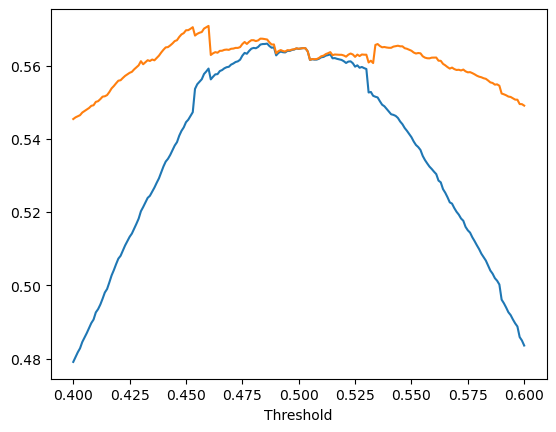

In [34]:
threshold_3 = determine_best_thresh(model_3, x_train_3, y_train_3)

In [35]:
# Verify the model on the test set
y_pred_3 = model_3.predict(x_test_3)
# threshold_3 = 0.5
y_pred_3 = y_pred_3 > threshold_3
print(classification_report(y_test_3, y_pred_3, digits=3))

              precision    recall  f1-score   support

         0.0      0.588     0.539     0.562      4648
         1.0      0.575     0.623     0.598      4647

    accuracy                          0.581      9295
   macro avg      0.581     0.581     0.580      9295
weighted avg      0.581     0.581     0.580      9295



In [36]:
x_big = valid_games_reg.copy().drop(columns=['finished', 'source', 'target'])

x_big['shortest_path_count'] = x_big['shortest_path_count'].apply(lambda x: np.log(x + 1e-4))
x_big['one_longer_path_count'] = x_big['one_longer_path_count'].apply(lambda x: np.log(x + 1e-4))

y_big = valid_games_reg['finished']


# standardization
scaler = StandardScaler()

x_train_big, x_test_big, y_train_big, y_test_big = train_test_split(x_big, y_big, train_size = 0.80, random_state = 42, stratify = y_big)

x_train_big = scaler.fit_transform(x_train_big) 
# x_train_big = sm.add_constant(x_train_big)

x_test_big = scaler.transform(x_test_big)
# x_test_big = sm.add_constant(x_test_big)

In [37]:
model_big = sm.Logit(y_train_big, x_train_big).fit()
model_big.summary()

Optimization terminated successfully.
         Current function value: 0.451152
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                37179
Model:                          Logit   Df Residuals:                    37155
Method:                           MLE   Df Model:                           23
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                  0.3491
Time:                        10:01:52   Log-Likelihood:                -16773.
converged:                       True   LL-Null:                       -25771.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.6151      0.023    -71.745      0.000      -1.659      -1.571
x2            -1.1395      0.025    -45.413      0.000      -1.189      -1.090
x3             1.7676      0.028     62.291      0.000       1.712       1.823
x4            -0.9288      0.032    -28.973      0.000      -0.992      -0.866
x5             0.1753      0.037      4.700      0.000       0.102       0.248
x6            -0.0734      0.047     -1.557      0.119      -0.166       0.019
x7             0.0243      0.060      0.404      0.686      -0.093       0.142
x8             0.0403      0.033      1.209      0.227      -0.025       0.106
x9             0.2267      0.040      5.689      0.000       0.149       0.305
x10           -0.1298      0.028     -4.704      0.000      -0.184      -0.076
x11            0.2188      0.044      4.986      0.000       0.133       0.305
x12           -0.0659      0.034     -1.912      0.056      -0.134       0.002
x13            0.0060      0.019      0.325      0.746      -0.030       0.042
x14            0.0036      0.022      0.166      0.868      -0.039       0.046
x15            0.0376      0.029      1.317      0.188      -0.018       0.094
x16            0.0349      0.015      2.303      0.021       0.005       0.065
x17           -0.0218      0.028     -0.769      0.442      -0.077       0.034
x18           -0.2459      0.025     -9.754      0.000      -0.295      -0.196
x19            0.0827      0.030      2.792      0.005       0.025       0.141
x20           -0.0655      0.027     -2.439      0.015      -0.118      -0.013
x21            0.2247      0.032      7.010      0.000       0.162       0.288
x22           -0.1829      0.026     -7.041      0.000      -0.234      -0.132
x23           -0.1613      0.032     -5.051      0.000      -0.224      -0.099
x24            0.2703      0.037      7.219      0.000       0.197       0.344
==============================================================================
"""

Max F1 Score:  0.8279004125015353
Threshold: 0.5770


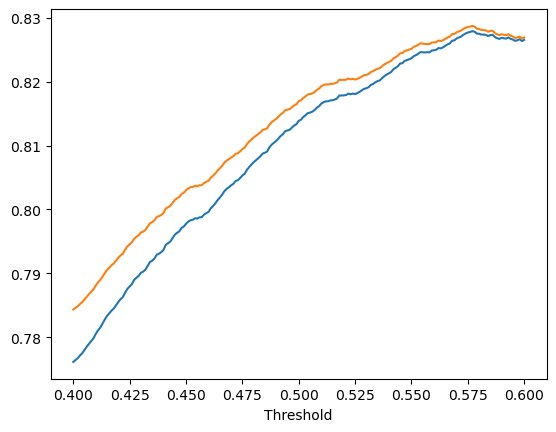

In [38]:
threshold_big = determine_best_thresh(model_big, x_train_big, y_train_big)

In [39]:
# Verify the model on the test set
y_pred_big = model_big.predict(x_test_big)
y_pred_big = y_pred_big > threshold_big
print(classification_report(y_test_big, y_pred_big, digits=4))

              precision    recall  f1-score   support

         0.0     0.8813    0.7685    0.8211      4648
         1.0     0.7947    0.8965    0.8426      4647

    accuracy                         0.8325      9295
   macro avg     0.8380    0.8325    0.8318      9295
weighted avg     0.8380    0.8325    0.8318      9295



In [40]:
print(confusion_matrix(y_test_big, y_pred_big))

[[3572 1076]
 [ 481 4166]]


In [41]:
from sklearn.ensemble import RandomForestClassifier

X_forrest = valid_games_reg.copy().drop(columns=['finished', 'source', 'target'])
y_forrest = valid_games_reg['finished']

X_train, X_test, y_train, y_test = train_test_split(X_forrest, y_forrest, train_size = 0.80, random_state = 42, stratify = y_forrest)

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=32, random_state=42, criterion='entropy', n_jobs=-1, max_features=8)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.894     0.817     0.854      4648
         1.0      0.831     0.904     0.866      4647

    accuracy                          0.860      9295
   macro avg      0.863     0.860     0.860      9295
weighted avg      0.863     0.860     0.860      9295



In [42]:
# The third model takes in the predicted values from the first two models and the cosine similarity
combined_pred = valid_games_reg.copy()[['finished']]

scaler = StandardScaler()

# x_1_star = valid_games_reg.copy().drop(columns=['finished', 'source', 'target'])
x_1_star = valid_games_reg.copy()[x_1_features]
x_1_star['shortest_path_count'] = x_1['shortest_path_count'].apply(lambda x: np.log(x + 1e-4))
x_1_star = scaler.fit_transform(x_1_star)
combined_pred['model_1_pred'] = model_1.predict(x_1_star)

x_2_star = valid_games_reg.copy()[x_2_features]
x_2_star = scaler.fit_transform(x_2_star)
x_2_star = sm.add_constant(x_2_star)
combined_pred['model_2_pred'] = model_2.predict(x_2_star)

x_3_star = valid_games_reg.copy().drop(columns=['finished', 'source', 'target'])
x_3_star = scaler.fit_transform(x_3_star)
combined_pred['model_3_pred'] = model_big.predict(x_3_star)

# Check how accurate the prediction is when both models agree
combined_pred['model_1_pred'] = combined_pred['model_1_pred'] > threshold_1
combined_pred['model_2_pred'] = combined_pred['model_2_pred'] > threshold_2
combined_pred['model_3_pred'] = combined_pred['model_3_pred'] > threshold_3

combined_pred['model_agree'] = ~(combined_pred['model_1_pred'] ^ combined_pred['model_2_pred'])

# Do majority voting
combined_pred['combined_pred'] = combined_pred[['model_1_pred', 'model_2_pred', 'model_3_pred']].sum(axis=1) > 1

predictions_align = combined_pred[combined_pred['model_agree'] == True]
predictions_misalign = combined_pred[combined_pred['model_agree'] == False]

# Count how many games are won when both models agree
print("Total number of games:                               ", combined_pred.shape[0])
print()
print("Num of instances when both models agree:              {0}".format(predictions_align.shape[0]))
print("Accuracy when both models agree:                     ", 
      np.sum(predictions_align['model_1_pred'] == predictions_align['finished']) / predictions_align.shape[0]
)

print()
agree_win = np.sum(predictions_align['finished'] == True)
print("Accuracy when both models agree and it is a win:     ",
      np.sum((predictions_align['model_1_pred'] == True) & (predictions_align['finished'] == True)) / agree_win
)
print("Num of instances when its a win and models agree:    ", agree_win)

agree_loss = np.sum(predictions_align['finished'] == False)
print("Accuracy when both models agree and it is a loss:    ",
      np.sum((predictions_align['model_1_pred'] == False) & (predictions_align['finished'] == False)) / agree_loss
)
print("Num of instances when its a loss and models agree:   ", agree_loss)


print()
print("Num of instances when they disagree:                        {0}".format(predictions_misalign.shape[0]))

first_disagree_total = np.sum(predictions_misalign['model_1_pred'] == predictions_misalign['finished'])
print("Accuracy of the first model when they disagree:            ", 
      first_disagree_total / predictions_misalign.shape[0]
)
second_disagree_total = np.sum(predictions_misalign['model_2_pred'] == predictions_misalign['finished'])
print("Accuracy of the second model when they disagree:           ", 
      second_disagree_total / predictions_misalign.shape[0]
)

print()
first_disagree_win = np.sum((predictions_misalign['model_1_pred'] == True) & (predictions_misalign['finished'] == True))
print("Accuracy of first when they disagree and it's a win:       ", 
      first_disagree_win / np.sum(predictions_misalign['finished'] == True)
)
print("Num of instances when its a win and models disagree:       ", first_disagree_win)

second_disagree_win = np.sum((predictions_misalign['model_2_pred'] == True) & (predictions_misalign['finished'] == True))
print("Accuracy of second when they disagree and it's a win:      ",
      second_disagree_win / np.sum(predictions_misalign['finished'] == True)
)
print("Num of instances when its a win and models disagree:       ", second_disagree_win)

first_disagree_loss = np.sum((predictions_misalign['model_1_pred'] == False) & (predictions_misalign['finished'] == False))
print("Accuracy of first when they disagree and it's a loss:      ", 
      first_disagree_loss / np.sum(predictions_misalign['finished'] == False)
)
print("Num of instances when its a loss and models disagree:      ", first_disagree_loss)

second_disagree_loss = np.sum((predictions_misalign['model_2_pred'] == False) & (predictions_misalign['finished'] == False))
print("Accuracy of second when they disagree and it's a loss:     ", 
      second_disagree_loss / np.sum(predictions_misalign['finished'] == False)
)
print("Num of instances when its a loss and models disagree:      ", second_disagree_loss)




Total number of games:                                46474

Num of instances when both models agree:              33633
Accuracy when both models agree:                      0.6662206761216662

Accuracy when both models agree and it is a win:      0.7933598478298461
Num of instances when its a win and models agree:     17349
Accuracy when both models agree and it is a loss:     0.5307663964627856
Num of instances when its a loss and models agree:    16284

Num of instances when they disagree:                        12841
Accuracy of the first model when they disagree:             0.44054201386184877
Accuracy of the second model when they disagree:            0.5594579861381512

Accuracy of first when they disagree and it's a win:        0.8525815217391305
Num of instances when its a win and models disagree:        5020
Accuracy of second when they disagree and it's a win:       0.14741847826086957
Num of instances when its a win and models disagree:        868
Accuracy of first when t

C:\Users\bgabe\AppData\Local\Temp\ipykernel_30900\4101531457.py:8: RuntimeWarning: invalid value encountered in log
  x_1_star['shortest_path_count'] = x_1['shortest_path_count'].apply(lambda x: np.log(x + 1e-4))


In [43]:
print(classification_report(predictions_align['finished'], predictions_align['combined_pred'], digits=3))

              precision    recall  f1-score   support

         0.0      0.707     0.531     0.606     16284
         1.0      0.643     0.793     0.710     17349

    accuracy                          0.666     33633
   macro avg      0.675     0.662     0.658     33633
weighted avg      0.674     0.666     0.660     33633

